# Ternary Decision System Analysis

Deep analysis of UP/DOWN/NO_DECISION performance

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd()))

from core.prediction_database import PredictionDatabase

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Load database
db = PredictionDatabase()
all_preds = db.get_predictions()
with_actuals = db.get_predictions(with_actuals=True)

print(f"Total predictions: {len(all_preds)}")
print(f"With actuals: {len(with_actuals)}")

Total predictions: 493
With actuals: 273


## 1. Overall Breakdown

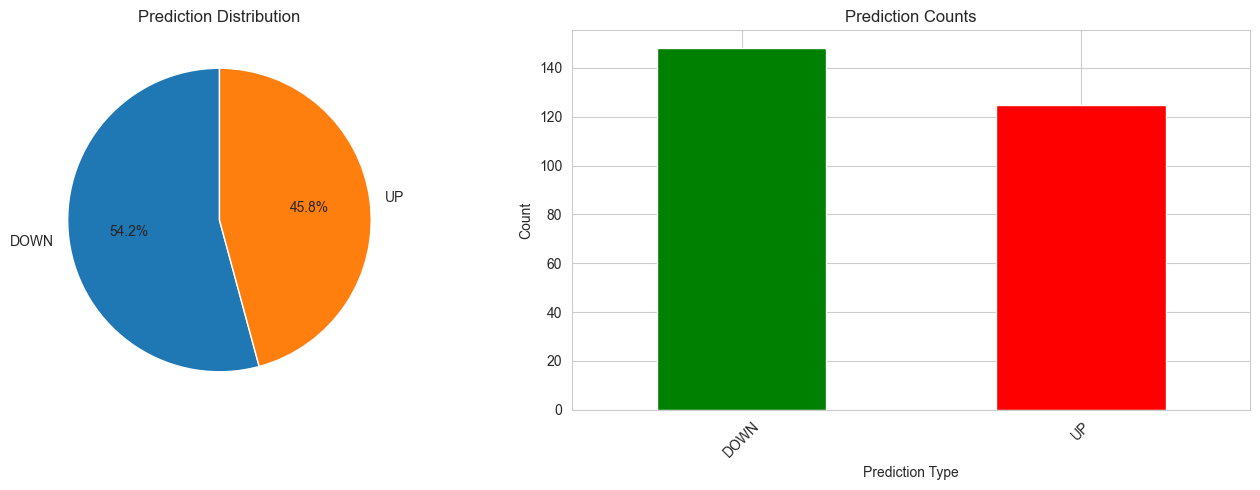


Prediction Breakdown:
direction_prediction
DOWN    148
UP      125
Name: count, dtype: int64

NO_DECISION Rate: 0.0%


In [2]:
# Prediction type counts
pred_counts = with_actuals['direction_prediction'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
pred_counts.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90)
axes[0].set_ylabel('')
axes[0].set_title('Prediction Distribution')

# Bar chart with counts
pred_counts.plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'])
axes[1].set_title('Prediction Counts')
axes[1].set_xlabel('Prediction Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nPrediction Breakdown:")
print(pred_counts)
print(f"\nNO_DECISION Rate: {pred_counts.get('NO_DECISION', 0) / len(with_actuals) * 100:.1f}%")

## 2. Directional Signal Performance (UP/DOWN only)

/var/folders/x7/wx6vsrv14yb8t8zyw52zj5r80000gn/T/ipykernel_69282/3362023383.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conf_acc = decisions.groupby(conf_bins)['direction_correct'].agg(['mean', 'count'])


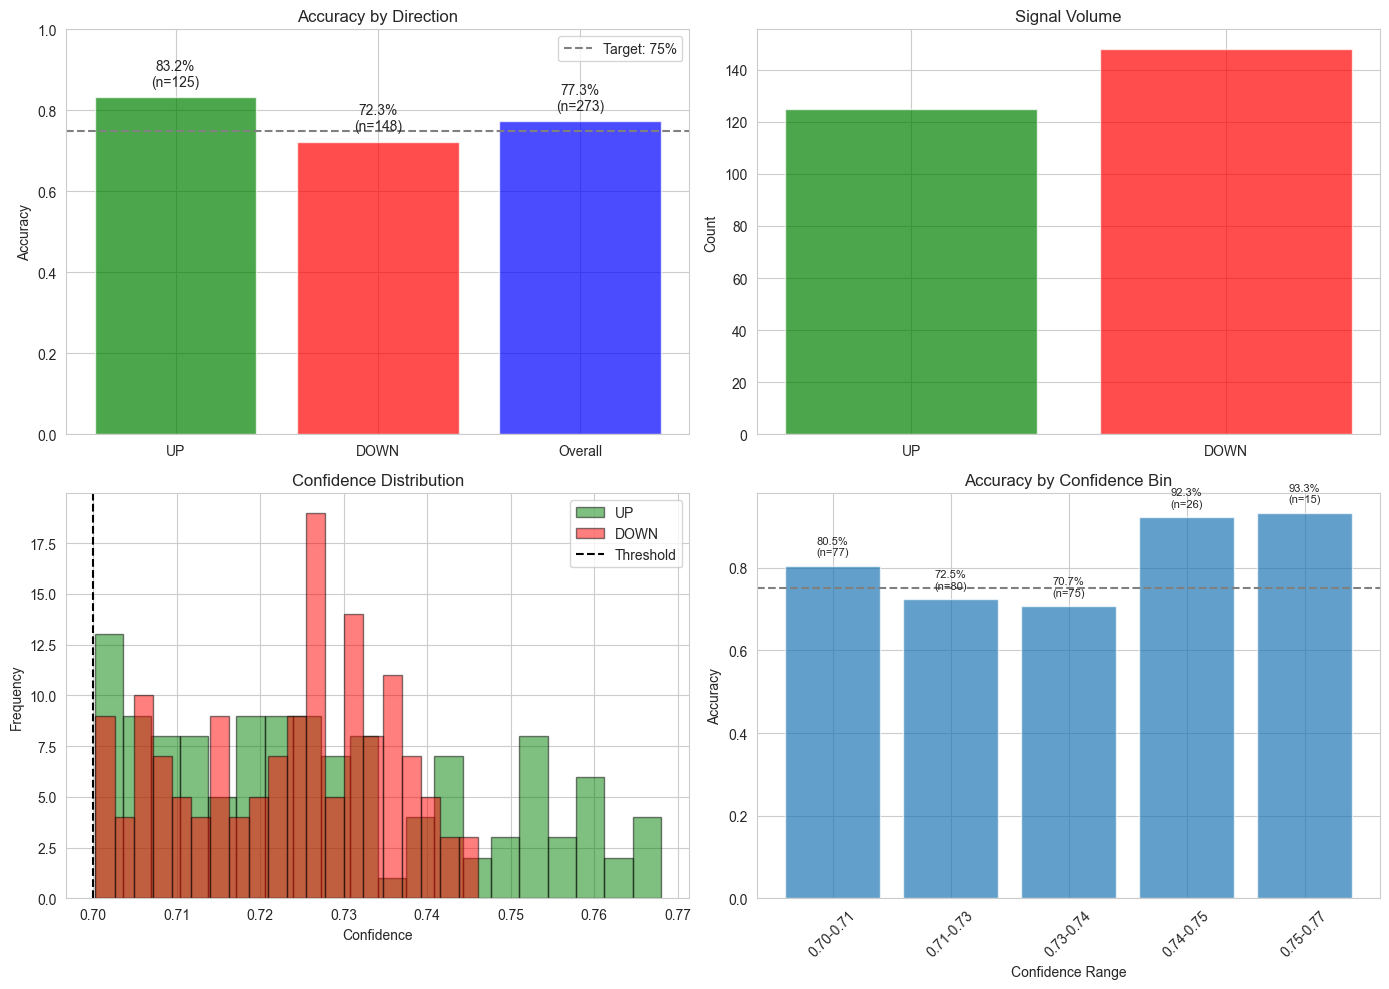


DIRECTIONAL PERFORMANCE SUMMARY

UP Signals:
  Count: 125
  Accuracy: 83.2%
  Avg Confidence: 72.8%
  MAE: 10.32%

DOWN Signals:
  Count: 148
  Accuracy: 72.3%
  Avg Confidence: 72.3%
  MAE: 18.59%

Overall:
  Accuracy: 77.3%
  MAE: 14.80%


In [3]:
# Filter to decisions only
decisions = with_actuals[with_actuals['direction_prediction'].isin(['UP', 'DOWN'])].copy()

if len(decisions) > 0:
    up_preds = decisions[decisions['direction_prediction'] == 'UP']
    down_preds = decisions[decisions['direction_prediction'] == 'DOWN']
    
    # Accuracy comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Accuracy by direction
    accuracy_data = pd.DataFrame({
        'Direction': ['UP', 'DOWN', 'Overall'],
        'Accuracy': [
            up_preds['direction_correct'].mean() if len(up_preds) > 0 else 0,
            down_preds['direction_correct'].mean() if len(down_preds) > 0 else 0,
            decisions['direction_correct'].mean()
        ],
        'Count': [len(up_preds), len(down_preds), len(decisions)]
    })
    
    axes[0, 0].bar(accuracy_data['Direction'], accuracy_data['Accuracy'], 
                   color=['green', 'red', 'blue'], alpha=0.7)
    axes[0, 0].axhline(y=0.75, color='gray', linestyle='--', label='Target: 75%')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].set_title('Accuracy by Direction')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    
    for i, row in accuracy_data.iterrows():
        axes[0, 0].text(i, row['Accuracy'] + 0.02, f"{row['Accuracy']:.1%}\n(n={row['Count']})",
                       ha='center', va='bottom')
    
    # 2. Signal volume
    axes[0, 1].bar(['UP', 'DOWN'], [len(up_preds), len(down_preds)],
                   color=['green', 'red'], alpha=0.7)
    axes[0, 1].set_title('Signal Volume')
    axes[0, 1].set_ylabel('Count')
    
    # 3. Confidence distribution
    if len(up_preds) > 0:
        axes[1, 0].hist(up_preds['direction_confidence'], bins=20, alpha=0.5, 
                       label='UP', color='green', edgecolor='black')
    if len(down_preds) > 0:
        axes[1, 0].hist(down_preds['direction_confidence'], bins=20, alpha=0.5,
                       label='DOWN', color='red', edgecolor='black')
    axes[1, 0].axvline(x=0.70, color='black', linestyle='--', label='Threshold')
    axes[1, 0].set_title('Confidence Distribution')
    axes[1, 0].set_xlabel('Confidence')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # 4. Accuracy vs Confidence
    conf_bins = pd.cut(decisions['direction_confidence'], bins=5)
    conf_acc = decisions.groupby(conf_bins)['direction_correct'].agg(['mean', 'count'])
    
    x_pos = range(len(conf_acc))
    axes[1, 1].bar(x_pos, conf_acc['mean'], alpha=0.7)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([f"{interval.left:.2f}-{interval.right:.2f}" 
                                 for interval in conf_acc.index], rotation=45)
    axes[1, 1].set_title('Accuracy by Confidence Bin')
    axes[1, 1].set_xlabel('Confidence Range')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].axhline(y=0.75, color='gray', linestyle='--')
    
    for i, (acc, cnt) in enumerate(zip(conf_acc['mean'], conf_acc['count'])):
        axes[1, 1].text(i, acc + 0.02, f"{acc:.1%}\n(n={int(cnt)})",
                       ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("DIRECTIONAL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"\nUP Signals:")
    print(f"  Count: {len(up_preds)}")
    if len(up_preds) > 0:
        print(f"  Accuracy: {up_preds['direction_correct'].mean():.1%}")
        print(f"  Avg Confidence: {up_preds['direction_confidence'].mean():.1%}")
        print(f"  MAE: {up_preds['magnitude_error'].mean():.2f}%")
    
    print(f"\nDOWN Signals:")
    print(f"  Count: {len(down_preds)}")
    if len(down_preds) > 0:
        print(f"  Accuracy: {down_preds['direction_correct'].mean():.1%}")
        print(f"  Avg Confidence: {down_preds['direction_confidence'].mean():.1%}")
        print(f"  MAE: {down_preds['magnitude_error'].mean():.2f}%")
    
    print(f"\nOverall:")
    print(f"  Accuracy: {decisions['direction_correct'].mean():.1%}")
    print(f"  MAE: {decisions['magnitude_error'].mean():.2f}%")
else:
    print("No directional predictions with actuals yet")

## 3. NO_DECISION Analysis

In [4]:
no_decisions = with_actuals[with_actuals['direction_prediction'] == 'NO_DECISION'].copy()

if len(no_decisions) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confidence distribution of NO_DECISION
    axes[0].hist(no_decisions['direction_confidence'], bins=20, 
                 color='gray', alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0.70, color='red', linestyle='--', label='Threshold')
    axes[0].set_title('NO_DECISION Confidence Distribution')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    
    # What would have happened if we forced predictions?
    would_predict_up = (no_decisions['prob_up'] > 0.5).sum()
    would_predict_down = len(no_decisions) - would_predict_up
    actual_up = (no_decisions['actual_direction'] == 1).sum()
    actual_down = (no_decisions['actual_direction'] == 0).sum()
    
    x = ['Would Predict\nUP', 'Would Predict\nDOWN']
    predicted = [would_predict_up, would_predict_down]
    
    axes[1].bar(x, predicted, alpha=0.7, label='Forced Predictions', color='lightblue')
    axes[1].set_title('NO_DECISION: What If We Forced Predictions?')
    axes[1].set_ylabel('Count')
    axes[1].legend()
    
    # Calculate hypothetical accuracy
    hypothetical_correct = 0
    for idx, row in no_decisions.iterrows():
        pred = 1 if row['prob_up'] > 0.5 else 0
        if pred == row['actual_direction']:
            hypothetical_correct += 1
    
    hyp_acc = hypothetical_correct / len(no_decisions)
    
    axes[1].text(0.5, max(predicted) * 0.9, 
                f"Hypothetical Accuracy:\n{hyp_acc:.1%}",
                ha='center', fontsize=12, bbox=dict(boxstyle='round', 
                facecolor='yellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("NO_DECISION ANALYSIS")
    print("="*60)
    print(f"\nNO_DECISION Count: {len(no_decisions)}")
    print(f"NO_DECISION Rate: {len(no_decisions)/len(with_actuals)*100:.1f}%")
    print(f"\nIf we had forced predictions:")
    print(f"  Would predict UP: {would_predict_up}")
    print(f"  Would predict DOWN: {would_predict_down}")
    print(f"  Actual UP outcomes: {actual_up}")
    print(f"  Actual DOWN outcomes: {actual_down}")
    print(f"  Hypothetical accuracy: {hyp_acc:.1%}")
    print(f"\n✅ By using NO_DECISION, we avoided {len(no_decisions)} predictions")
    print(f"   that would have been only {hyp_acc:.1%} accurate")
else:
    print("No NO_DECISION predictions with actuals yet")

No NO_DECISION predictions with actuals yet


## 4. Time Series Analysis

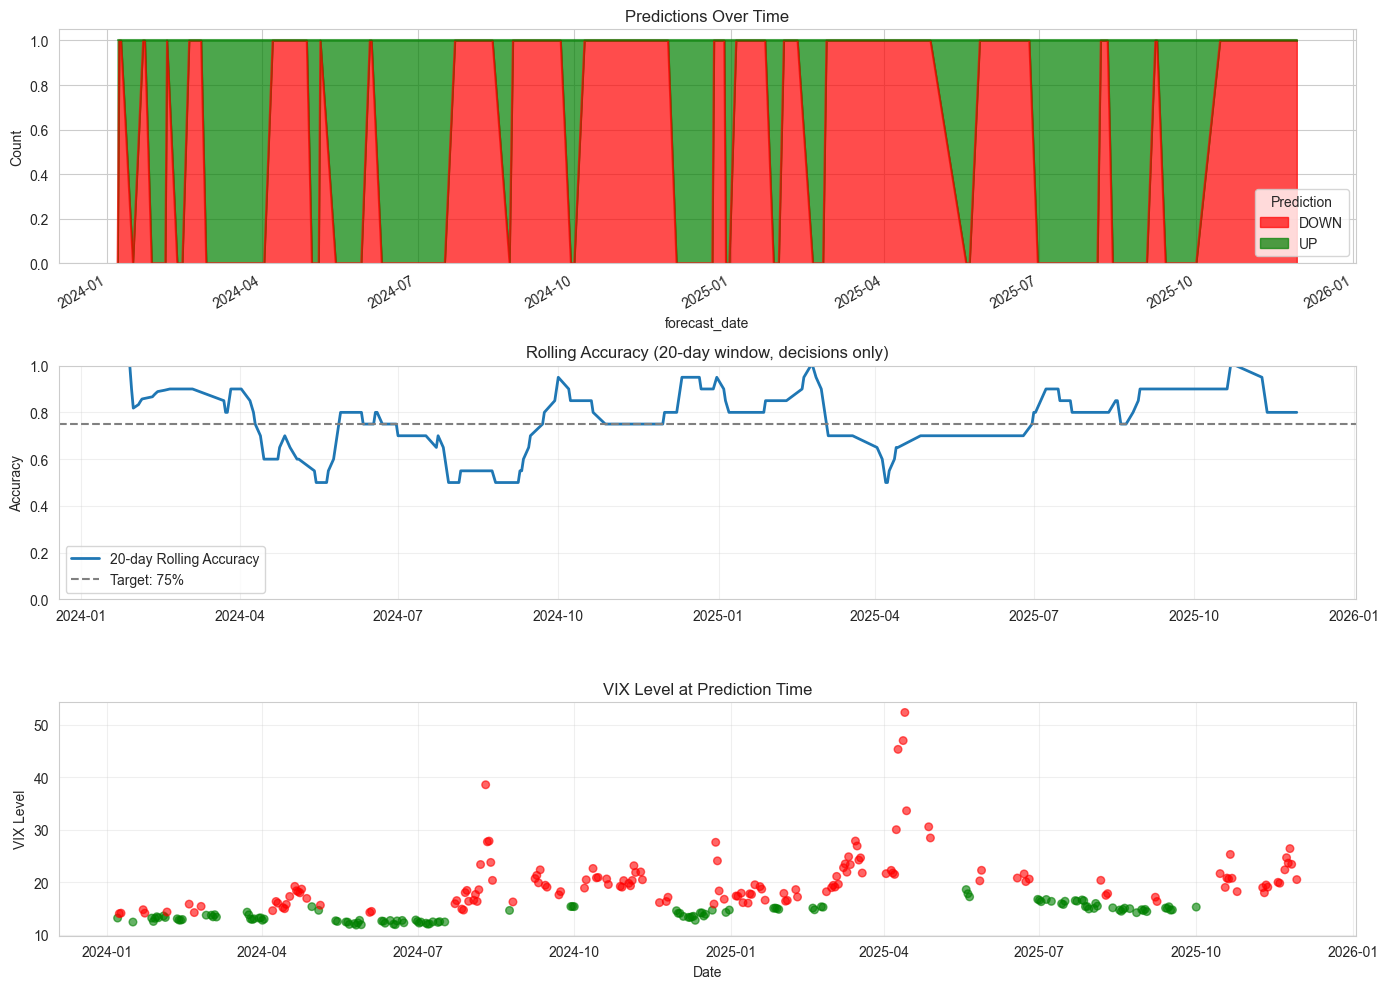

In [5]:
if len(with_actuals) > 0:
    with_actuals_sorted = with_actuals.sort_values('forecast_date')
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # 1. Predictions over time
    pred_by_date = with_actuals_sorted.groupby('forecast_date')['direction_prediction'].value_counts().unstack(fill_value=0)
    pred_by_date.plot(kind='area', stacked=True, ax=axes[0], alpha=0.7,
                     color={'UP': 'green', 'DOWN': 'red', 'NO_DECISION': 'gray'})
    axes[0].set_title('Predictions Over Time')
    axes[0].set_ylabel('Count')
    axes[0].legend(title='Prediction')
    
    # 2. Rolling accuracy (decisions only)
    if len(decisions) > 0:
        decisions_sorted = decisions.sort_values('forecast_date')
        decisions_sorted['rolling_acc'] = decisions_sorted['direction_correct'].rolling(window=20, min_periods=5).mean()
        axes[1].plot(decisions_sorted['forecast_date'], decisions_sorted['rolling_acc'], 
                    linewidth=2, label='20-day Rolling Accuracy')
        axes[1].axhline(y=0.75, color='gray', linestyle='--', label='Target: 75%')
        axes[1].set_title('Rolling Accuracy (20-day window, decisions only)')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_ylim([0, 1])
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    # 3. VIX level at prediction time
    axes[2].scatter(with_actuals_sorted['forecast_date'], 
                   with_actuals_sorted['current_vix'],
                   c=with_actuals_sorted['direction_prediction'].map(
                       {'UP': 'green', 'DOWN': 'red', 'NO_DECISION': 'gray'}),
                   alpha=0.6, s=30)
    axes[2].set_title('VIX Level at Prediction Time')
    axes[2].set_ylabel('VIX Level')
    axes[2].set_xlabel('Date')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Cohort Analysis

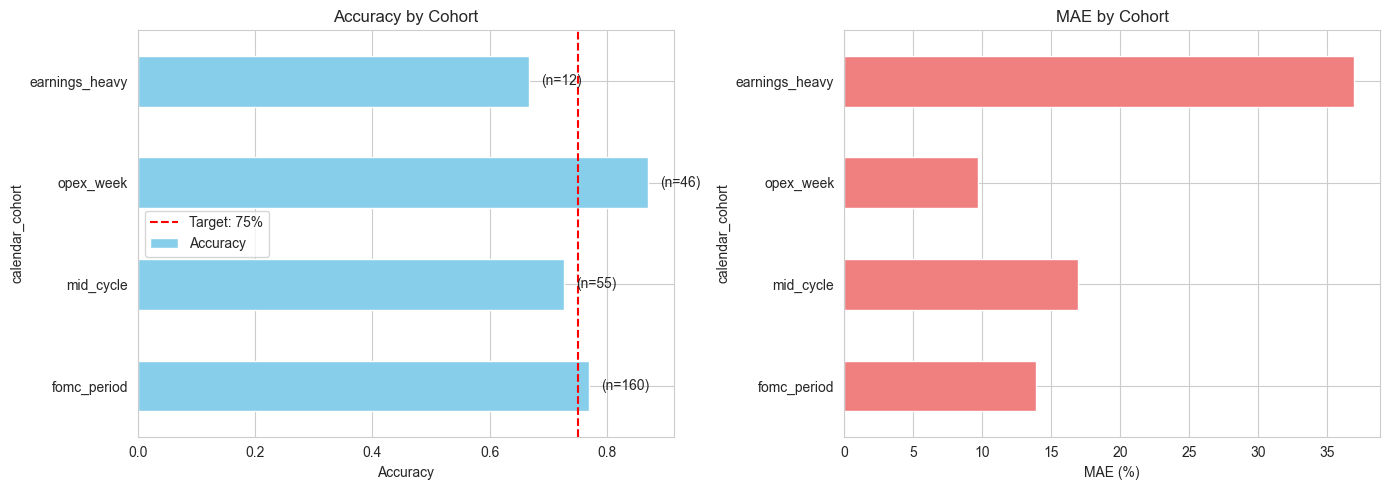


COHORT PERFORMANCE
                 Accuracy  Count     MAE  Avg_Confidence
calendar_cohort                                         
fomc_period         0.769    160  13.878           0.726
mid_cycle           0.727     55  16.926           0.723
opex_week           0.870     46   9.694           0.726
earnings_heavy      0.667     12  36.991           0.726


In [6]:
if len(decisions) > 0:
    # Performance by cohort
    cohort_stats = decisions.groupby('calendar_cohort').agg({
        'direction_correct': ['mean', 'count'],
        'magnitude_error': 'mean',
        'direction_confidence': 'mean'
    }).round(3)
    
    cohort_stats.columns = ['Accuracy', 'Count', 'MAE', 'Avg_Confidence']
    cohort_stats = cohort_stats.sort_values('Count', ascending=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy by cohort
    cohort_stats['Accuracy'].plot(kind='barh', ax=axes[0], color='skyblue')
    axes[0].axvline(x=0.75, color='red', linestyle='--', label='Target: 75%')
    axes[0].set_title('Accuracy by Cohort')
    axes[0].set_xlabel('Accuracy')
    axes[0].legend()
    
    # Add counts as annotations
    for i, (idx, row) in enumerate(cohort_stats.iterrows()):
        axes[0].text(row['Accuracy'] + 0.02, i, f"(n={int(row['Count'])})",
                    va='center')
    
    # MAE by cohort
    cohort_stats['MAE'].plot(kind='barh', ax=axes[1], color='lightcoral')
    axes[1].set_title('MAE by Cohort')
    axes[1].set_xlabel('MAE (%)')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("COHORT PERFORMANCE")
    print("="*60)
    print(cohort_stats.to_string())

## 6. System Health Check

In [7]:
print("\n" + "="*80)
print("SYSTEM HEALTH CHECK")
print("="*80)

if len(decisions) > 0:
    # Calculate key metrics
    up_acc = up_preds['direction_correct'].mean() if len(up_preds) > 0 else 0
    down_acc = down_preds['direction_correct'].mean() if len(down_preds) > 0 else 0
    overall_acc = decisions['direction_correct'].mean()
    no_dec_rate = len(no_decisions) / len(with_actuals)
    balance_ratio = len(up_preds) / len(down_preds) if len(down_preds) > 0 else 999
    
    # Health checks
    checks = []
    
    # 1. Overall accuracy
    if overall_acc >= 0.75:
        checks.append(("✅", "Overall Accuracy", f"{overall_acc:.1%} (>= 75%)"))
    elif overall_acc >= 0.70:
        checks.append(("⚠️", "Overall Accuracy", f"{overall_acc:.1%} (70-75%)"))
    else:
        checks.append(("❌", "Overall Accuracy", f"{overall_acc:.1%} (< 70%)"))
    
    # 2. Balance
    acc_diff = abs(up_acc - down_acc)
    if acc_diff < 0.10:
        checks.append(("✅", "Accuracy Balance", f"Diff={acc_diff:.1%} (< 10%)"))
    elif acc_diff < 0.15:
        checks.append(("⚠️", "Accuracy Balance", f"Diff={acc_diff:.1%} (10-15%)"))
    else:
        checks.append(("❌", "Accuracy Balance", f"Diff={acc_diff:.1%} (> 15%)"))
    
    # 3. Signal ratio
    if 0.6 <= balance_ratio <= 1.5:
        checks.append(("✅", "Signal Ratio", f"UP/DOWN={balance_ratio:.2f} (0.6-1.5)"))
    elif 0.4 <= balance_ratio <= 2.0:
        checks.append(("⚠️", "Signal Ratio", f"UP/DOWN={balance_ratio:.2f} (borderline)"))
    else:
        checks.append(("❌", "Signal Ratio", f"UP/DOWN={balance_ratio:.2f} (imbalanced)"))
    
    # 4. NO_DECISION rate
    if 0.30 <= no_dec_rate <= 0.50:
        checks.append(("✅", "NO_DECISION Rate", f"{no_dec_rate:.1%} (30-50%)"))
    elif 0.20 <= no_dec_rate <= 0.60:
        checks.append(("⚠️", "NO_DECISION Rate", f"{no_dec_rate:.1%} (borderline)"))
    else:
        checks.append(("❌", "NO_DECISION Rate", f"{no_dec_rate:.1%} (suboptimal)"))
    
    # 5. Sample size
    if len(decisions) >= 100:
        checks.append(("✅", "Sample Size", f"n={len(decisions)} (>= 100)"))
    elif len(decisions) >= 50:
        checks.append(("⚠️", "Sample Size", f"n={len(decisions)} (50-100)"))
    else:
        checks.append(("❌", "Sample Size", f"n={len(decisions)} (< 50)"))
    
    # Print results
    for status, check, value in checks:
        print(f"{status} {check:20s}: {value}")
    
    # Overall health
    good = sum(1 for s, _, _ in checks if s == "✅")
    warn = sum(1 for s, _, _ in checks if s == "⚠️")
    bad = sum(1 for s, _, _ in checks if s == "❌")
    
    print("\n" + "="*80)
    if good >= 4:
        print("✅ SYSTEM HEALTH: GOOD")
        print("   System is performing well. Continue monitoring.")
    elif good + warn >= 4:
        print("⚠️  SYSTEM HEALTH: FAIR")
        print("   System has some issues. Consider tuning.")
    else:
        print("❌ SYSTEM HEALTH: POOR")
        print("   System needs attention. Run tuner or adjust threshold.")
else:
    print("\n⚠️  Insufficient data for health check")
    print("   Need at least 50 directional predictions with actuals")


SYSTEM HEALTH CHECK
✅ Overall Accuracy    : 77.3% (>= 75%)
⚠️ Accuracy Balance    : Diff=10.9% (10-15%)
✅ Signal Ratio        : UP/DOWN=0.84 (0.6-1.5)
❌ NO_DECISION Rate    : 0.0% (suboptimal)
✅ Sample Size         : n=273 (>= 100)

⚠️  SYSTEM HEALTH: FAIR
   System has some issues. Consider tuning.


## 7. Recommendations

In [8]:
print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

if len(decisions) >= 50:
    recs = []
    
    # Threshold recommendations
    if no_dec_rate > 0.55:
        recs.append("🔧 Lower decision_threshold (0.70 → 0.65) for more signals")
    elif no_dec_rate < 0.25:
        recs.append("🔧 Raise decision_threshold (0.70 → 0.75) for higher quality")
    
    # Balance recommendations
    if abs(up_acc - down_acc) > 0.10:
        recs.append("🔧 Run tuner to fix accuracy imbalance:")
        recs.append("   $ python unified_tuner_upgraded.py --frozen 200")
    
    # Performance recommendations
    if overall_acc < 0.70:
        recs.append("🔧 Overall accuracy low - consider:")
        recs.append("   1. Retrain models: python train_probabilistic_models.py")
        recs.append("   2. Run tuner: python unified_tuner_upgraded.py --frozen 200")
    
    if len(recs) == 0:
        print("\n✅ System is performing well!")
        print("   No immediate action needed.")
        print("   Continue monitoring performance.")
    else:
        print("\nSuggested Actions:")
        for rec in recs:
            print(f"  {rec}")
else:
    print("\n⏳ Need more data before making recommendations")
    print("   Current: {} decisions with actuals".format(len(decisions)))
    print("   Target: 50+ for meaningful analysis")
    print("   Continue running system and check back later")


RECOMMENDATIONS

Suggested Actions:
  🔧 Raise decision_threshold (0.70 → 0.75) for higher quality
  🔧 Run tuner to fix accuracy imbalance:
     $ python unified_tuner_upgraded.py --frozen 200
